# Prediction
附上test data的連結
[link!](https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols)

In [24]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [28]:
import tensorflow.keras.preprocessing.image as tfimage

def load_datasets(path):
  clean = []
  types = []
  label = []

  # loop over every folder
  i = -1
  k = 0
  for folder in os.listdir(path):
    i += 1
    label.append(folder)
    print(i, ": ", folder)
    for file in os.listdir(path + '/' + folder):
        # image = tfimage.load_img(path + '/' + folder + '/' + file, target_size=(256,256))
        # image = tfimage.img_to_array(image).astype('float32') / 255
        img = tfimage.load_img(path + '/' + folder + '/' + file)
        img = cv2.imread(os.path.join(path,folder,file),cv2.IMREAD_GRAYSCALE) # Convert to Image to Grayscale bc contour
        img=~img # Invert the bits of image 255 -> 0 / test the dataset
        if img is not None:
          ret,thresh=cv2.threshold(img,127,255,cv2.THRESH_BINARY) # THRESH_BINARY: Set bits > 127 to 1(white background) and <= 127 to 0(black) 
          ctrs, ret = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # determine object boundary, remove background
          cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
          w=int(45)
          h=int(45)
          # maximum area of the rectangle
          maxi=0
          for c in cnt: # traverse in all the rectangles we have
            x,y,w,h=cv2.boundingRect(c)
            maxi=max(w*h,maxi)
            if maxi==w*h:
              x_max=x
              y_max=y
              w_max=w
              h_max=h
          im_crop= thresh[y_max:y_max+h_max+10, x_max:x_max+w_max+10] # add 10 extra margin to avoid error
          im_resize = cv2.resize(im_crop,(45,45))
          im_resize =  tfimage.img_to_array(im_resize).astype('float32') / 255
          #im_resize=np.reshape(im_resize,(784,1)) #resize to (28,28)
          clean.append(im_resize) # flat the matrix
          types.append(i)

  types = tf.one_hot(types, depth=i+1)
  types = np.array(types)
  clean = np.array(clean)

  print("image shape: ", clean.shape)
  print("label shape: ", types.shape)
  
  return types, clean, label

**load model and test data (for prediction)**

In [27]:
modelpath = "C:\\Users\\USER\\Desktop\\MathHelper\\little_helper.h5"
classifier = tf.keras.models.load_model(modelpath)
datapath = "C:\\Users\\USER\\Desktop\\MathHelper\\dataset"
types, clean, label = load_datasets(datapath)

0 :  !
1 :  +
2 :  -
3 :  0
4 :  1
5 :  2
6 :  3
7 :  4
8 :  5
9 :  6
10 :  7
11 :  8
12 :  9
13 :  cos
14 :  div
15 :  log
16 :  pi
17 :  sin
18 :  tan
19 :  x
image shape:  (172847, 45, 45, 1)
label shape:  (172847, 20)


**prediction**

In [6]:
class_num = 20
scores = classifier.evaluate(
        x = clean,
        y = types,
        batch_size = 64,
        verbose = 2)

print("test loss: ", scores[0])
print("test accuracy: ", scores[1])

8520/8520 - 25s - loss: 0.0930 - accuracy: 0.9759
test loss:  0.09300395101308823
test accuracy:  0.9759091734886169


In [7]:
# for visualize
results = classifier.predict(clean)

In [9]:
total = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
wrong = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i in range(clean.shape[0]):
    answer = np.where(results[i] == np.max(results[i]))[0][0]
    reality = np.where(types[i] == 1)[0][0]
    total[reality] += 1
    if (answer != reality):
        wrong[reality] += 1

wrong_rate = [round(int(w) / int(t) * 100, 2) for w, t in zip(wrong, total)]

In [10]:
import pandas as pd  

data = {'label': label, 'wrong rate (%)': wrong_rate}  
df = pd.DataFrame(data)  

print(df)  

   label  wrong rate (%)
0      !           19.38
1      +            1.42
2      -            0.19
3      0            1.50
4      1            0.97
5      2            1.68
6      3            0.57
7      4            1.69
8      5            5.08
9      6            2.85
10     7            7.84
11     8            1.24
12     9            8.38
13   cos            8.37
14   div           88.48
15   log            0.70
16    pi           19.13
17   sin            2.31
18     x            0.65


VISUALIZE-PREDICTED-RESULT---------------------------
! 0.0 %
+ 0.011 %
- 0.681 %
0 3.651 %
1 4.43 %
2 31.549 %
3 3.525 %
4 0.547 %
5 0.94 %
6 0.025 %
7 0.501 %
8 0.624 %
9 51.243 %
predict:  9
reality:  5


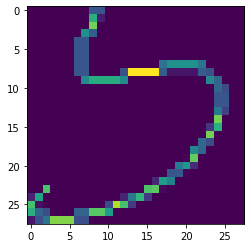

In [23]:
tmp = np.random.randint(0, len(clean))
answer = np.where(results[tmp] == np.max(results[tmp]))[0][0]
reality = np.where(types[tmp] == 1)[0][0]

print("VISUALIZE-PREDICTED-RESULT---------------------------")
for p in range(class_num):
    print(label[p], round(results[tmp][p]*100, 3), '%')

print("predict: ", label[answer])
print("reality: ", label[reality])
plt.imshow(clean[tmp])
plt.show()